<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix

!pip install open3d;
import open3d as o3d

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

import time
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 3.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.7 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.7.1
    Uninstalling nbformat-5.7.1:
      Successfully uninstalled nbformat-5.7.1


In [2]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-01-29 10:14:50--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-01-29 10:14:50--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  37.5MB/s    in 13s     

2023-01-29 10:15:04 (34.6 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [3]:
!unzip -q ModelNet10.zip;

In [4]:
import os

ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)


100%|██████████| 101/101 [02:28<00:00,  1.47s/it]


In [5]:
class VoxelDataset(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label = Y['train']
      else:
          self.data = X['test']
          self.label = Y['test']
        
                
    def __len__(self):
        return len(self.label)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1

        #flip x
        if np.random.randint(2):
            vox_g = np.flip(vox_g, axis=0)
        
        #flip y
        if np.random.randint(2):
            vox_g = np.flip(vox_g, axis=1)
        
        angle = 360 * np.random.random_sample(1)[0]
        vox_g = rotate(vox_g, axes=(0, 1), angle=angle, cval=0.0, reshape=False)  
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label = self.label[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label

In [6]:
from collections import OrderedDict
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

In [19]:
from collections import OrderedDict
class BatchVoxNet(nn.Module):
    def __init__(self):
        super(BatchVoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('batch2', torch.nn.BatchNorm3d(32)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

In [8]:
from collections import OrderedDict
class DMPVoxNet(nn.Module):
    def __init__(self, n_classes=10, data_size=32):
        super().__init__()
        self.n_classes = n_classes
        self.data_size = data_size
        input_shape = (self.data_size,self.data_size,self.data_size)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(2)),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, self.n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

In [11]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

class VoxNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel(hyperparameters)
  
  def initDataset(self):
      self.train_ds = VoxelDataset(train=True)
      self.test_ds = VoxelDataset(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self, hyperparameters):
      if hyperparameters["model"] == "VoxNet":
          self.model = VoxNet()
          print("model VoxNet was chosen")
      elif hyperparameters["model"] == "BatchVoxNet":
          self.model = BatchVoxNet()
          print("model BatchVoxNet was chosen")
      else:
          self.model = DMPVoxNet()
          print("model DMPVoxNet was chosen")
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.loss_fn = nn.CrossEntropyLoss()
      self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          self.lr_scheduler.step()
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data[0], data[1]
              inputs = inputs.to(self.device)
              labels = labels.to(self.device)

              self.opt.zero_grad()
              pred = self.model(inputs)  # torch.Size([256, 10])
              loss = self.loss_fn(pred,labels)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(pred, 1).cpu(), labels.cpu()) 

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              pred_choice = pred.data.max(1)[1]
              correct = pred_choice.eq(labels.data).cpu().sum()
                      
          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test = sample[0], sample[1]
                inputs_test = inputs_test.to(self.device)
                labels_test = labels_test.to(self.device)
                inputs_test = inputs_test.float()  # 转float, torch.Size([256, 1, 32, 32, 32])
                
                pred_test = self.model(inputs_test)
                loss_test = self.loss_fn(pred_test, labels_test)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(pred_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = pred_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test, 1))
                self.y_conf.append(labels_test)

          #compute confusion matrix
          a = torch.cat(self.pred_conf).cpu()
          b = torch.cat(self.y_conf).cpu()
          confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
          self.conf_matrix = confmat(a, b)
          self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

          # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()
          train_accuracy.reset()
          valid_accuracy.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")
          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)
        
      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

**VoxNet** training

In [12]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'VoxNet'
}    

trainer1 = VoxNet_Trainer(training_hyperparameters)
trainer1.train()

model VoxNet was chosen
124.71875


Train loss: 1.1990453004837036: : 124it [01:14,  1.67it/s]
29it [00:10,  2.82it/s]


epoch:  1 /100
time: 84.72 seconds
train-loss: 1.67, train-acc: 42.99%
valid-loss: 1.51, valid-acc: 47.14%



Train loss: 1.1013157367706299: : 124it [01:23,  1.48it/s]
29it [00:10,  2.89it/s]


epoch:  2 /100
time: 93.59 seconds
train-loss: 1.23, train-acc: 57.71%
valid-loss: 1.43, valid-acc: 42.07%



Train loss: 0.7461034655570984: : 124it [01:15,  1.63it/s]
29it [00:09,  2.95it/s]


epoch:  3 /100
time: 85.85 seconds
train-loss: 1.04, train-acc: 64.09%
valid-loss: 1.04, valid-acc: 61.56%



Train loss: 0.5703095197677612: : 124it [01:12,  1.71it/s]
29it [00:09,  2.98it/s]


epoch:  4 /100
time: 82.37 seconds
train-loss: 0.87, train-acc: 69.83%
valid-loss: 0.94, valid-acc: 65.42%



Train loss: 1.038921594619751: : 124it [01:12,  1.71it/s]
29it [00:09,  3.00it/s]


epoch:  5 /100
time: 82.12 seconds
train-loss: 0.80, train-acc: 72.13%
valid-loss: 0.91, valid-acc: 66.52%



Train loss: 1.2823694944381714: : 124it [01:12,  1.71it/s]
29it [00:09,  2.95it/s]


epoch:  6 /100
time: 82.40 seconds
train-loss: 0.74, train-acc: 74.80%
valid-loss: 0.79, valid-acc: 71.70%



Train loss: 0.7770859599113464: : 124it [01:12,  1.71it/s]
29it [00:09,  2.97it/s]


epoch:  7 /100
time: 82.44 seconds
train-loss: 0.68, train-acc: 76.89%
valid-loss: 0.71, valid-acc: 75.44%



Train loss: 0.8847332000732422: : 124it [01:12,  1.71it/s]
29it [00:10,  2.89it/s]


epoch:  8 /100
time: 82.51 seconds
train-loss: 0.64, train-acc: 78.63%
valid-loss: 0.73, valid-acc: 72.58%



Train loss: 0.2803792655467987: : 124it [01:14,  1.66it/s]
29it [00:09,  2.98it/s]


epoch:  9 /100
time: 84.63 seconds
train-loss: 0.62, train-acc: 79.33%
valid-loss: 0.69, valid-acc: 75.77%



Train loss: 0.46596547961235046: : 124it [01:15,  1.65it/s]
29it [00:09,  2.96it/s]


epoch: 10 /100
time: 84.99 seconds
train-loss: 0.55, train-acc: 81.93%
valid-loss: 0.70, valid-acc: 75.11%



Train loss: 0.41032886505126953: : 124it [01:12,  1.71it/s]
29it [00:09,  2.97it/s]


epoch: 11 /100
time: 82.43 seconds
train-loss: 0.55, train-acc: 81.20%
valid-loss: 0.65, valid-acc: 77.64%



Train loss: 0.12278357148170471: : 124it [01:12,  1.71it/s]
29it [00:09,  2.93it/s]


epoch: 12 /100
time: 82.60 seconds
train-loss: 0.53, train-acc: 82.94%
valid-loss: 0.64, valid-acc: 77.75%



Train loss: 0.3549526035785675: : 124it [01:12,  1.71it/s]
29it [00:09,  2.98it/s]


epoch: 13 /100
time: 82.40 seconds
train-loss: 0.51, train-acc: 83.39%
valid-loss: 0.58, valid-acc: 80.84%



Train loss: 0.37601229548454285: : 124it [01:12,  1.71it/s]
29it [00:09,  2.98it/s]


epoch: 14 /100
time: 82.31 seconds
train-loss: 0.48, train-acc: 84.58%
valid-loss: 0.61, valid-acc: 79.41%



Train loss: 0.5041983127593994: : 124it [01:13,  1.69it/s]
29it [00:09,  2.91it/s]


epoch: 15 /100
time: 83.21 seconds
train-loss: 0.47, train-acc: 83.77%
valid-loss: 0.60, valid-acc: 79.30%



Train loss: 0.25554415583610535: : 124it [01:13,  1.70it/s]
29it [00:09,  2.93it/s]


epoch: 16 /100
time: 83.03 seconds
train-loss: 0.44, train-acc: 85.51%
valid-loss: 0.59, valid-acc: 79.52%



Train loss: 0.47149351239204407: : 124it [01:12,  1.70it/s]
29it [00:09,  2.91it/s]


epoch: 17 /100
time: 82.89 seconds
train-loss: 0.41, train-acc: 86.32%
valid-loss: 0.62, valid-acc: 79.19%



Train loss: 0.4912046194076538: : 124it [01:12,  1.70it/s]
29it [00:09,  2.97it/s]


epoch: 18 /100
time: 82.69 seconds
train-loss: 0.40, train-acc: 86.42%
valid-loss: 0.58, valid-acc: 81.50%



Train loss: 0.36090603470802307: : 124it [01:12,  1.71it/s]
29it [00:09,  2.96it/s]


epoch: 19 /100
time: 82.32 seconds
train-loss: 0.40, train-acc: 86.06%
valid-loss: 0.51, valid-acc: 82.82%



Train loss: 0.335597962141037: : 124it [01:13,  1.69it/s]
29it [00:09,  2.98it/s]


epoch: 20 /100
time: 82.95 seconds
train-loss: 0.38, train-acc: 87.02%
valid-loss: 0.53, valid-acc: 83.26%



Train loss: 0.4184274971485138: : 124it [01:13,  1.69it/s]
29it [00:10,  2.79it/s]


epoch: 21 /100
time: 83.70 seconds
train-loss: 0.37, train-acc: 87.73%
valid-loss: 0.51, valid-acc: 82.60%



Train loss: 0.32895782589912415: : 124it [01:16,  1.63it/s]
29it [00:10,  2.82it/s]


epoch: 22 /100
time: 86.54 seconds
train-loss: 0.36, train-acc: 87.53%
valid-loss: 0.55, valid-acc: 83.15%



Train loss: 0.31907200813293457: : 124it [01:15,  1.65it/s]
29it [00:09,  2.93it/s]


epoch: 23 /100
time: 85.21 seconds
train-loss: 0.36, train-acc: 87.55%
valid-loss: 0.53, valid-acc: 81.50%



Train loss: 0.1661798357963562: : 124it [01:15,  1.65it/s]
29it [00:10,  2.89it/s]


epoch: 24 /100
time: 85.34 seconds
train-loss: 0.35, train-acc: 88.18%
valid-loss: 0.53, valid-acc: 80.84%



Train loss: 0.3199041485786438: : 124it [01:15,  1.64it/s]
29it [00:10,  2.87it/s]


epoch: 25 /100
time: 85.68 seconds
train-loss: 0.34, train-acc: 88.31%
valid-loss: 0.49, valid-acc: 83.48%



Train loss: 0.47978758811950684: : 124it [01:16,  1.63it/s]
29it [00:10,  2.86it/s]


epoch: 26 /100
time: 86.20 seconds
train-loss: 0.35, train-acc: 88.36%
valid-loss: 0.52, valid-acc: 83.26%



Train loss: 0.3913932740688324: : 124it [01:15,  1.63it/s]
29it [00:10,  2.84it/s]


epoch: 27 /100
time: 86.24 seconds
train-loss: 0.34, train-acc: 88.61%
valid-loss: 0.50, valid-acc: 83.26%



Train loss: 0.36319029331207275: : 124it [01:15,  1.64it/s]
29it [00:10,  2.90it/s]


epoch: 28 /100
time: 85.64 seconds
train-loss: 0.32, train-acc: 88.91%
valid-loss: 0.53, valid-acc: 80.95%



Train loss: 0.21840794384479523: : 124it [01:15,  1.64it/s]
29it [00:10,  2.88it/s]


epoch: 29 /100
time: 85.60 seconds
train-loss: 0.33, train-acc: 88.61%
valid-loss: 0.48, valid-acc: 84.03%



Train loss: 0.4830162823200226: : 124it [01:15,  1.64it/s]
29it [00:10,  2.83it/s]


epoch: 30 /100
time: 85.93 seconds
train-loss: 0.33, train-acc: 89.04%
valid-loss: 0.47, valid-acc: 84.47%



Train loss: 0.16594675183296204: : 124it [01:15,  1.64it/s]
29it [00:10,  2.75it/s]


epoch: 31 /100
time: 86.22 seconds
train-loss: 0.31, train-acc: 89.72%
valid-loss: 0.51, valid-acc: 84.91%



Train loss: 0.3213610053062439: : 124it [01:19,  1.57it/s]
29it [00:10,  2.85it/s]


epoch: 32 /100
time: 89.35 seconds
train-loss: 0.30, train-acc: 89.92%
valid-loss: 0.48, valid-acc: 84.58%



Train loss: 0.5073481798171997: : 124it [01:14,  1.67it/s]
29it [00:10,  2.88it/s]


epoch: 33 /100
time: 84.30 seconds
train-loss: 0.29, train-acc: 89.67%
valid-loss: 0.51, valid-acc: 84.03%



Train loss: 0.07737956941127777: : 124it [01:14,  1.67it/s]
29it [00:10,  2.88it/s]


epoch: 34 /100
time: 84.33 seconds
train-loss: 0.28, train-acc: 90.37%
valid-loss: 0.54, valid-acc: 83.04%



Train loss: 0.09409569203853607: : 124it [01:15,  1.64it/s]
29it [00:10,  2.87it/s]


epoch: 35 /100
time: 85.55 seconds
train-loss: 0.27, train-acc: 90.57%
valid-loss: 0.49, valid-acc: 84.69%



Train loss: 0.1544768065214157: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 36 /100
time: 84.52 seconds
train-loss: 0.29, train-acc: 91.05%
valid-loss: 0.47, valid-acc: 84.91%



Train loss: 0.06281837821006775: : 124it [01:13,  1.69it/s]
29it [00:09,  2.91it/s]


epoch: 37 /100
time: 83.47 seconds
train-loss: 0.26, train-acc: 91.23%
valid-loss: 0.47, valid-acc: 84.25%



Train loss: 0.44814518094062805: : 124it [01:13,  1.68it/s]
29it [00:10,  2.90it/s]


epoch: 38 /100
time: 83.81 seconds
train-loss: 0.27, train-acc: 90.60%
valid-loss: 0.50, valid-acc: 84.47%



Train loss: 0.3602585792541504: : 124it [01:13,  1.68it/s]
29it [00:10,  2.86it/s]


epoch: 39 /100
time: 83.91 seconds
train-loss: 0.27, train-acc: 90.93%
valid-loss: 0.47, valid-acc: 85.46%



Train loss: 0.3601771891117096: : 124it [01:15,  1.63it/s]
29it [00:10,  2.87it/s]


epoch: 40 /100
time: 85.99 seconds
train-loss: 0.28, train-acc: 90.27%
valid-loss: 0.47, valid-acc: 83.81%



Train loss: 0.2917388081550598: : 124it [01:15,  1.64it/s]
29it [00:10,  2.88it/s]


epoch: 41 /100
time: 85.67 seconds
train-loss: 0.25, train-acc: 91.63%
valid-loss: 0.48, valid-acc: 85.79%



Train loss: 0.15421828627586365: : 124it [01:14,  1.66it/s]
29it [00:10,  2.87it/s]


epoch: 42 /100
time: 84.90 seconds
train-loss: 0.26, train-acc: 91.10%
valid-loss: 0.49, valid-acc: 84.47%



Train loss: 0.38625308871269226: : 124it [01:14,  1.67it/s]
29it [00:09,  2.93it/s]


epoch: 43 /100
time: 84.32 seconds
train-loss: 0.25, train-acc: 91.26%
valid-loss: 0.48, valid-acc: 83.70%



Train loss: 0.12376227229833603: : 124it [01:13,  1.69it/s]
29it [00:09,  2.92it/s]


epoch: 44 /100
time: 83.40 seconds
train-loss: 0.27, train-acc: 90.93%
valid-loss: 0.48, valid-acc: 84.25%



Train loss: 0.2441604882478714: : 124it [01:14,  1.67it/s]
29it [00:09,  2.90it/s]


epoch: 45 /100
time: 84.50 seconds
train-loss: 0.26, train-acc: 91.43%
valid-loss: 0.48, valid-acc: 84.58%



Train loss: 0.17083057761192322: : 124it [01:12,  1.70it/s]
29it [00:09,  2.92it/s]


epoch: 46 /100
time: 82.81 seconds
train-loss: 0.25, train-acc: 91.46%
valid-loss: 0.50, valid-acc: 83.37%



Train loss: 0.19174253940582275: : 124it [01:12,  1.70it/s]
29it [00:09,  2.98it/s]


epoch: 47 /100
time: 82.70 seconds
train-loss: 0.25, train-acc: 91.08%
valid-loss: 0.52, valid-acc: 84.58%



Train loss: 0.5156079530715942: : 124it [01:12,  1.70it/s]
29it [00:09,  2.95it/s]


epoch: 48 /100
time: 82.77 seconds
train-loss: 0.23, train-acc: 91.78%
valid-loss: 0.44, valid-acc: 85.90%



Train loss: 0.09853467345237732: : 124it [01:12,  1.70it/s]
29it [00:09,  2.95it/s]


epoch: 49 /100
time: 82.84 seconds
train-loss: 0.23, train-acc: 91.89%
valid-loss: 0.48, valid-acc: 85.02%



Train loss: 0.19883428514003754: : 124it [01:13,  1.70it/s]
29it [00:09,  2.93it/s]


epoch: 50 /100
time: 83.06 seconds
train-loss: 0.23, train-acc: 91.89%
valid-loss: 0.47, valid-acc: 85.68%



Train loss: 0.1542847603559494: : 124it [01:12,  1.70it/s]
29it [00:09,  2.96it/s]


epoch: 51 /100
time: 82.82 seconds
train-loss: 0.22, train-acc: 92.34%
valid-loss: 0.48, valid-acc: 85.46%



Train loss: 0.10588791221380234: : 124it [01:13,  1.69it/s]
29it [00:09,  2.91it/s]


epoch: 52 /100
time: 83.45 seconds
train-loss: 0.22, train-acc: 92.69%
valid-loss: 0.50, valid-acc: 85.24%



Train loss: 0.38028883934020996: : 124it [01:13,  1.69it/s]
29it [00:09,  2.95it/s]


epoch: 53 /100
time: 83.23 seconds
train-loss: 0.22, train-acc: 92.44%
valid-loss: 0.47, valid-acc: 84.03%



Train loss: 0.3121287226676941: : 124it [01:13,  1.70it/s]
29it [00:09,  2.92it/s]


epoch: 54 /100
time: 83.08 seconds
train-loss: 0.23, train-acc: 91.99%
valid-loss: 0.50, valid-acc: 85.13%



Train loss: 0.16492360830307007: : 124it [01:13,  1.69it/s]
29it [00:09,  2.93it/s]


epoch: 55 /100
time: 83.34 seconds
train-loss: 0.20, train-acc: 93.27%
valid-loss: 0.48, valid-acc: 84.58%



Train loss: 0.1606438159942627: : 124it [01:13,  1.69it/s]
29it [00:09,  2.94it/s]


epoch: 56 /100
time: 83.16 seconds
train-loss: 0.21, train-acc: 92.59%
valid-loss: 0.46, valid-acc: 86.12%



Train loss: 0.1260078102350235: : 124it [01:12,  1.70it/s]
29it [00:09,  2.93it/s]


epoch: 57 /100
time: 82.84 seconds
train-loss: 0.20, train-acc: 93.07%
valid-loss: 0.51, valid-acc: 85.35%



Train loss: 0.2074248045682907: : 124it [01:13,  1.70it/s]
29it [00:09,  2.95it/s]


epoch: 58 /100
time: 82.88 seconds
train-loss: 0.21, train-acc: 92.79%
valid-loss: 0.47, valid-acc: 84.69%



Train loss: 0.3253622353076935: : 124it [01:12,  1.70it/s]
29it [00:09,  2.96it/s]


epoch: 59 /100
time: 82.80 seconds
train-loss: 0.21, train-acc: 92.44%
valid-loss: 0.50, valid-acc: 85.24%



Train loss: 0.12852194905281067: : 124it [01:12,  1.70it/s]
29it [00:09,  2.96it/s]


epoch: 60 /100
time: 82.64 seconds
train-loss: 0.20, train-acc: 92.94%
valid-loss: 0.45, valid-acc: 85.35%



Train loss: 0.0924220085144043: : 124it [01:12,  1.71it/s]
29it [00:09,  2.94it/s]


epoch: 61 /100
time: 82.62 seconds
train-loss: 0.21, train-acc: 92.94%
valid-loss: 0.49, valid-acc: 84.25%



Train loss: 0.09660177677869797: : 124it [01:12,  1.70it/s]
29it [00:09,  2.92it/s]


epoch: 62 /100
time: 82.93 seconds
train-loss: 0.20, train-acc: 92.99%
valid-loss: 0.51, valid-acc: 84.14%



Train loss: 0.27241653203964233: : 124it [01:13,  1.70it/s]
29it [00:09,  2.94it/s]


epoch: 63 /100
time: 83.03 seconds
train-loss: 0.19, train-acc: 93.42%
valid-loss: 0.46, valid-acc: 86.34%



Train loss: 0.269819051027298: : 124it [01:13,  1.70it/s]
29it [00:09,  2.94it/s]


epoch: 64 /100
time: 83.01 seconds
train-loss: 0.21, train-acc: 92.59%
valid-loss: 0.46, valid-acc: 86.01%



Train loss: 0.10794451087713242: : 124it [01:13,  1.69it/s]
29it [00:09,  2.93it/s]


epoch: 65 /100
time: 83.22 seconds
train-loss: 0.19, train-acc: 92.72%
valid-loss: 0.46, valid-acc: 86.34%



Train loss: 0.12372574210166931: : 124it [01:13,  1.69it/s]
29it [00:09,  2.93it/s]


epoch: 66 /100
time: 83.17 seconds
train-loss: 0.19, train-acc: 93.07%
valid-loss: 0.50, valid-acc: 84.58%



Train loss: 0.14459604024887085: : 124it [01:13,  1.70it/s]
29it [00:09,  2.94it/s]


epoch: 67 /100
time: 83.05 seconds
train-loss: 0.19, train-acc: 93.22%
valid-loss: 0.48, valid-acc: 85.79%



Train loss: 0.23022523522377014: : 124it [01:13,  1.70it/s]
29it [00:09,  2.94it/s]


epoch: 68 /100
time: 82.99 seconds
train-loss: 0.20, train-acc: 93.15%
valid-loss: 0.49, valid-acc: 86.67%



Train loss: 0.06555692106485367: : 124it [01:13,  1.70it/s]
29it [00:09,  2.95it/s]


epoch: 69 /100
time: 82.88 seconds
train-loss: 0.19, train-acc: 93.37%
valid-loss: 0.45, valid-acc: 86.34%



Train loss: 0.16635730862617493: : 124it [01:13,  1.70it/s]
29it [00:09,  2.94it/s]


epoch: 70 /100
time: 82.94 seconds
train-loss: 0.19, train-acc: 93.40%
valid-loss: 0.49, valid-acc: 85.35%



Train loss: 0.2241297960281372: : 124it [01:13,  1.69it/s]
29it [00:09,  2.94it/s]


epoch: 71 /100
time: 83.19 seconds
train-loss: 0.17, train-acc: 93.72%
valid-loss: 0.48, valid-acc: 86.45%



Train loss: 0.2046680599451065: : 124it [01:13,  1.69it/s]
29it [00:09,  2.92it/s]


epoch: 72 /100
time: 83.15 seconds
train-loss: 0.20, train-acc: 93.09%
valid-loss: 0.47, valid-acc: 85.35%



Train loss: 0.04978173226118088: : 124it [01:13,  1.69it/s]
29it [00:09,  2.94it/s]


epoch: 73 /100
time: 83.08 seconds
train-loss: 0.19, train-acc: 93.27%
valid-loss: 0.45, valid-acc: 86.45%



Train loss: 0.10273277759552002: : 124it [01:13,  1.70it/s]
29it [00:09,  2.93it/s]


epoch: 74 /100
time: 82.97 seconds
train-loss: 0.18, train-acc: 93.60%
valid-loss: 0.45, valid-acc: 86.45%



Train loss: 0.14737996459007263: : 124it [01:12,  1.70it/s]
29it [00:09,  2.95it/s]


epoch: 75 /100
time: 82.84 seconds
train-loss: 0.17, train-acc: 93.93%
valid-loss: 0.50, valid-acc: 86.23%



Train loss: 0.45224618911743164: : 124it [01:13,  1.70it/s]
29it [00:09,  2.94it/s]


epoch: 76 /100
time: 82.98 seconds
train-loss: 0.18, train-acc: 93.25%
valid-loss: 0.47, valid-acc: 86.23%



Train loss: 0.2224985808134079: : 124it [01:13,  1.70it/s]
29it [00:09,  2.96it/s]


epoch: 77 /100
time: 82.99 seconds
train-loss: 0.17, train-acc: 94.48%
valid-loss: 0.48, valid-acc: 86.67%



Train loss: 0.09273914247751236: : 124it [01:12,  1.70it/s]
29it [00:09,  2.95it/s]


epoch: 78 /100
time: 82.87 seconds
train-loss: 0.18, train-acc: 93.75%
valid-loss: 0.49, valid-acc: 85.57%



Train loss: 0.3350871205329895: : 124it [01:13,  1.70it/s]
29it [00:09,  2.92it/s]


epoch: 79 /100
time: 83.06 seconds
train-loss: 0.17, train-acc: 93.72%
valid-loss: 0.44, valid-acc: 87.00%



Train loss: 0.1601618230342865: : 124it [01:13,  1.69it/s]
29it [00:09,  2.91it/s]


epoch: 80 /100
time: 83.33 seconds
train-loss: 0.17, train-acc: 94.15%
valid-loss: 0.48, valid-acc: 86.34%



Train loss: 0.1470719426870346: : 124it [01:13,  1.69it/s]
29it [00:09,  2.94it/s]


epoch: 81 /100
time: 83.22 seconds
train-loss: 0.16, train-acc: 94.33%
valid-loss: 0.46, valid-acc: 87.33%



Train loss: 0.3678410053253174: : 124it [01:13,  1.69it/s]
29it [00:09,  2.92it/s]


epoch: 82 /100
time: 83.20 seconds
train-loss: 0.17, train-acc: 94.18%
valid-loss: 0.44, valid-acc: 86.67%



Train loss: 0.21400338411331177: : 124it [01:13,  1.70it/s]
29it [00:09,  2.93it/s]


epoch: 83 /100
time: 83.04 seconds
train-loss: 0.16, train-acc: 94.15%
valid-loss: 0.49, valid-acc: 86.01%



Train loss: 0.23255908489227295: : 124it [01:12,  1.70it/s]
29it [00:09,  2.92it/s]


epoch: 84 /100
time: 82.83 seconds
train-loss: 0.16, train-acc: 93.67%
valid-loss: 0.47, valid-acc: 85.46%



Train loss: 0.09115654230117798: : 124it [01:14,  1.66it/s]
29it [00:10,  2.85it/s]


epoch: 85 /100
time: 84.73 seconds
train-loss: 0.16, train-acc: 94.13%
valid-loss: 0.48, valid-acc: 86.23%



Train loss: 0.23743478953838348: : 124it [01:16,  1.62it/s]
29it [00:10,  2.84it/s]


epoch: 86 /100
time: 86.58 seconds
train-loss: 0.17, train-acc: 94.10%
valid-loss: 0.49, valid-acc: 84.91%



Train loss: 0.14332839846611023: : 124it [01:14,  1.66it/s]
29it [00:09,  2.91it/s]


epoch: 87 /100
time: 84.58 seconds
train-loss: 0.17, train-acc: 94.05%
valid-loss: 0.47, valid-acc: 86.01%



Train loss: 0.17168688774108887: : 124it [01:13,  1.68it/s]
29it [00:09,  2.93it/s]


epoch: 88 /100
time: 83.67 seconds
train-loss: 0.15, train-acc: 94.81%
valid-loss: 0.48, valid-acc: 86.01%



Train loss: 0.06546032428741455: : 124it [01:13,  1.69it/s]
29it [00:09,  2.92it/s]


epoch: 89 /100
time: 83.29 seconds
train-loss: 0.15, train-acc: 94.63%
valid-loss: 0.47, valid-acc: 86.56%



Train loss: 0.11685291677713394: : 124it [01:13,  1.70it/s]
29it [00:09,  2.92it/s]


epoch: 90 /100
time: 83.08 seconds
train-loss: 0.16, train-acc: 94.48%
valid-loss: 0.46, valid-acc: 87.33%



Train loss: 0.08816279470920563: : 124it [01:13,  1.69it/s]
29it [00:09,  2.94it/s]


epoch: 91 /100
time: 83.42 seconds
train-loss: 0.16, train-acc: 94.28%
valid-loss: 0.46, valid-acc: 86.67%



Train loss: 0.07996465265750885: : 124it [01:13,  1.69it/s]
29it [00:09,  2.95it/s]


epoch: 92 /100
time: 83.06 seconds
train-loss: 0.16, train-acc: 94.46%
valid-loss: 0.48, valid-acc: 86.23%



Train loss: 0.3902356028556824: : 124it [01:13,  1.70it/s]
29it [00:09,  2.95it/s]


epoch: 93 /100
time: 83.03 seconds
train-loss: 0.16, train-acc: 94.20%
valid-loss: 0.47, valid-acc: 87.00%



Train loss: 0.09082109481096268: : 124it [01:13,  1.69it/s]
29it [00:09,  2.92it/s]


epoch: 94 /100
time: 83.14 seconds
train-loss: 0.16, train-acc: 94.46%
valid-loss: 0.47, valid-acc: 85.13%



Train loss: 0.27353569865226746: : 124it [01:13,  1.69it/s]
29it [00:09,  2.93it/s]


epoch: 95 /100
time: 83.13 seconds
train-loss: 0.16, train-acc: 94.10%
valid-loss: 0.45, valid-acc: 87.33%



Train loss: 0.11457916349172592: : 124it [01:13,  1.69it/s]
29it [00:09,  2.96it/s]


epoch: 96 /100
time: 83.02 seconds
train-loss: 0.15, train-acc: 94.73%
valid-loss: 0.45, valid-acc: 86.45%



Train loss: 0.11418500542640686: : 124it [01:13,  1.69it/s]
29it [00:09,  2.93it/s]


epoch: 97 /100
time: 83.36 seconds
train-loss: 0.16, train-acc: 94.15%
valid-loss: 0.47, valid-acc: 86.78%



Train loss: 0.2972443103790283: : 124it [01:13,  1.70it/s]
29it [00:10,  2.89it/s]


epoch: 98 /100
time: 83.14 seconds
train-loss: 0.15, train-acc: 94.68%
valid-loss: 0.48, valid-acc: 86.34%



Train loss: 0.26939159631729126: : 124it [01:14,  1.67it/s]
29it [00:09,  2.91it/s]


epoch: 99 /100
time: 84.36 seconds
train-loss: 0.15, train-acc: 94.30%
valid-loss: 0.47, valid-acc: 86.56%



Train loss: 0.31040239334106445: : 124it [01:13,  1.69it/s]
29it [00:09,  2.93it/s]

epoch:100 /100
time: 83.26 seconds
train-loss: 0.15, train-acc: 94.61%
valid-loss: 0.48, valid-acc: 85.90%



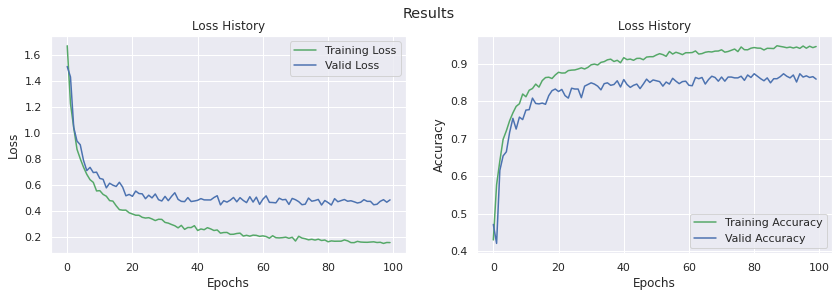

In [13]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history1 = trainer1.getHistory()
trainer1.showResults()

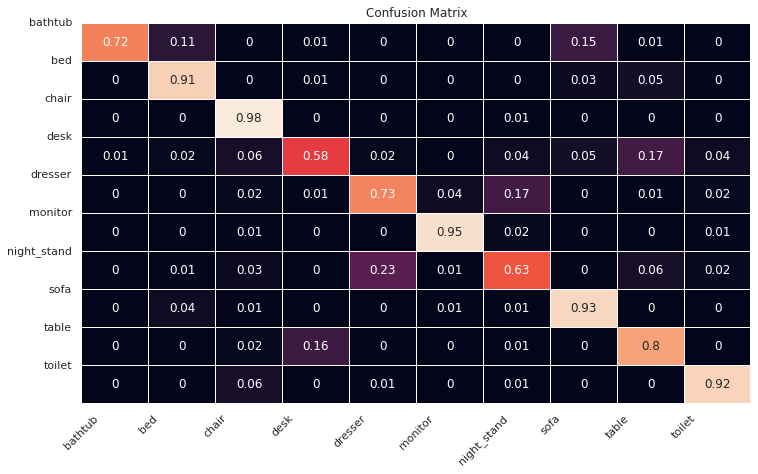

In [14]:
trainer1.generateConfusionMatrix()

In [15]:
trainer1.getPerClassAccuracy()

{'bathtub': 72.0, 'bed': 91.0, 'chair': 98.98989868164062, 'desk': 58.58585739135742, 'dresser': 73.0, 'monitor': 95.95960235595703, 'night_stand': 63.6363639831543, 'sofa': 93.0, 'table': 80.8080825805664, 'toilet': 92.0}


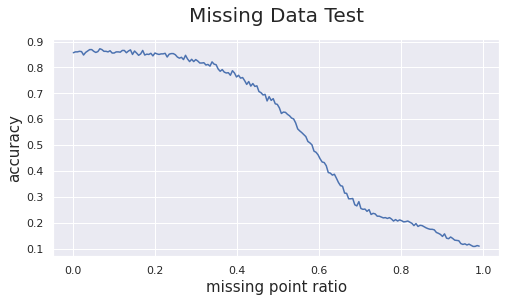

In [16]:
trainer1.missing_data_test()

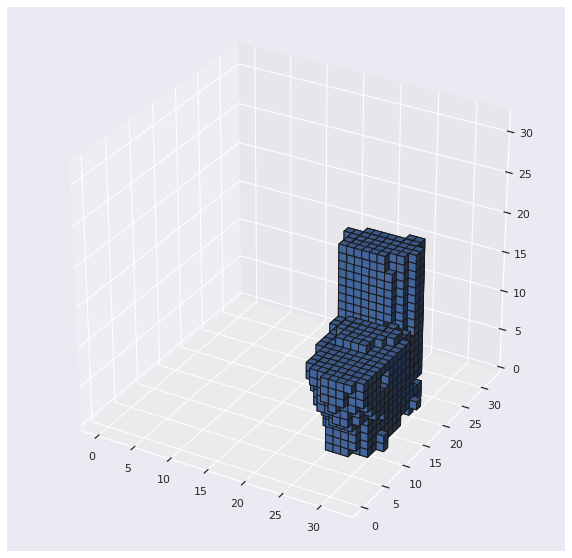

In [17]:
trainer1.draw_voxels()

**BatchVoxNet** Training 

In [20]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'BatchVoxNet'
}    

trainer2 = VoxNet_Trainer(training_hyperparameters)
trainer2.train()

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


model BatchVoxNet was chosen
124.71875


Train loss: 1.5804964303970337: : 124it [01:18,  1.59it/s]
29it [00:10,  2.89it/s]


epoch:  1 /100
time: 88.27 seconds
train-loss: 1.77, train-acc: 40.73%
valid-loss: 1.80, valid-acc: 40.86%



Train loss: 1.3494212627410889: : 124it [01:17,  1.59it/s]
29it [00:10,  2.86it/s]


epoch:  2 /100
time: 88.15 seconds
train-loss: 1.35, train-acc: 52.39%
valid-loss: 1.18, valid-acc: 57.93%



Train loss: 0.9883438348770142: : 124it [01:16,  1.63it/s]
29it [00:09,  2.93it/s]


epoch:  3 /100
time: 86.00 seconds
train-loss: 1.13, train-acc: 61.11%
valid-loss: 1.06, valid-acc: 62.67%



Train loss: 1.0325961112976074: : 124it [01:15,  1.63it/s]
29it [00:09,  2.93it/s]


epoch:  4 /100
time: 85.86 seconds
train-loss: 1.00, train-acc: 65.40%
valid-loss: 0.96, valid-acc: 65.31%



Train loss: 0.8778572082519531: : 124it [01:16,  1.62it/s]
29it [00:09,  2.92it/s]


epoch:  5 /100
time: 86.29 seconds
train-loss: 0.91, train-acc: 69.25%
valid-loss: 1.03, valid-acc: 61.56%



Train loss: 0.7161847352981567: : 124it [01:16,  1.62it/s]
29it [00:10,  2.90it/s]


epoch:  6 /100
time: 86.45 seconds
train-loss: 0.88, train-acc: 71.19%
valid-loss: 0.88, valid-acc: 68.72%



Train loss: 0.6529027819633484: : 124it [01:16,  1.62it/s]
29it [00:09,  2.92it/s]


epoch:  7 /100
time: 86.35 seconds
train-loss: 0.83, train-acc: 71.52%
valid-loss: 0.84, valid-acc: 67.73%



Train loss: 0.9540108442306519: : 124it [01:17,  1.61it/s]
29it [00:10,  2.85it/s]


epoch:  8 /100
time: 87.25 seconds
train-loss: 0.79, train-acc: 74.04%
valid-loss: 0.85, valid-acc: 69.60%



Train loss: 0.6007667779922485: : 124it [01:16,  1.62it/s]
29it [00:10,  2.89it/s]


epoch:  9 /100
time: 86.77 seconds
train-loss: 0.73, train-acc: 75.91%
valid-loss: 0.82, valid-acc: 71.37%



Train loss: 0.3777431845664978: : 124it [01:18,  1.59it/s]
29it [00:10,  2.79it/s]


epoch: 10 /100
time: 88.45 seconds
train-loss: 0.70, train-acc: 75.98%
valid-loss: 0.78, valid-acc: 72.03%



Train loss: 0.5333313941955566: : 124it [01:17,  1.59it/s]
29it [00:10,  2.88it/s]


epoch: 11 /100
time: 88.09 seconds
train-loss: 0.69, train-acc: 77.55%
valid-loss: 0.69, valid-acc: 75.88%



Train loss: 0.648476243019104: : 124it [01:17,  1.60it/s]
29it [00:10,  2.84it/s]


epoch: 12 /100
time: 87.79 seconds
train-loss: 0.67, train-acc: 77.44%
valid-loss: 0.71, valid-acc: 72.80%



Train loss: 0.7009656429290771: : 124it [01:17,  1.59it/s]
29it [00:09,  2.92it/s]


epoch: 13 /100
time: 87.73 seconds
train-loss: 0.64, train-acc: 78.12%
valid-loss: 0.68, valid-acc: 75.77%



Train loss: 0.28905218839645386: : 124it [01:16,  1.62it/s]
29it [00:10,  2.84it/s]


epoch: 14 /100
time: 86.85 seconds
train-loss: 0.62, train-acc: 79.99%
valid-loss: 0.68, valid-acc: 78.19%



Train loss: 0.3662841320037842: : 124it [01:16,  1.62it/s]
29it [00:09,  2.92it/s]


epoch: 15 /100
time: 86.47 seconds
train-loss: 0.61, train-acc: 79.69%
valid-loss: 0.63, valid-acc: 78.08%



Train loss: 0.6449266076087952: : 124it [01:16,  1.62it/s]
29it [00:09,  2.93it/s]


epoch: 16 /100
time: 86.31 seconds
train-loss: 0.55, train-acc: 81.48%
valid-loss: 0.60, valid-acc: 79.07%



Train loss: 0.2535703778266907: : 124it [01:16,  1.63it/s]
29it [00:09,  2.94it/s]


epoch: 17 /100
time: 86.01 seconds
train-loss: 0.54, train-acc: 82.33%
valid-loss: 0.57, valid-acc: 79.85%



Train loss: 0.29162418842315674: : 124it [01:15,  1.63it/s]
29it [00:09,  2.94it/s]


epoch: 18 /100
time: 85.85 seconds
train-loss: 0.51, train-acc: 82.54%
valid-loss: 0.60, valid-acc: 78.08%



Train loss: 0.5340462327003479: : 124it [01:15,  1.63it/s]
29it [00:09,  2.94it/s]


epoch: 19 /100
time: 85.87 seconds
train-loss: 0.50, train-acc: 83.14%
valid-loss: 0.59, valid-acc: 78.63%



Train loss: 0.6289590001106262: : 124it [01:15,  1.63it/s]
29it [00:09,  2.91it/s]


epoch: 20 /100
time: 85.98 seconds
train-loss: 0.49, train-acc: 83.85%
valid-loss: 0.56, valid-acc: 81.28%



Train loss: 0.9110661745071411: : 124it [01:15,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 21 /100
time: 85.92 seconds
train-loss: 0.48, train-acc: 84.40%
valid-loss: 0.64, valid-acc: 78.52%



Train loss: 0.5214331150054932: : 124it [01:16,  1.62it/s]
29it [00:09,  2.93it/s]


epoch: 22 /100
time: 86.50 seconds
train-loss: 0.49, train-acc: 83.49%
valid-loss: 0.57, valid-acc: 80.18%



Train loss: 0.38420170545578003: : 124it [01:16,  1.63it/s]
29it [00:09,  2.95it/s]


epoch: 23 /100
time: 85.92 seconds
train-loss: 0.48, train-acc: 84.40%
valid-loss: 0.55, valid-acc: 80.84%



Train loss: 0.4136603772640228: : 124it [01:16,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 24 /100
time: 85.95 seconds
train-loss: 0.45, train-acc: 84.75%
valid-loss: 0.57, valid-acc: 80.62%



Train loss: 0.7561674118041992: : 124it [01:15,  1.64it/s]
29it [00:09,  2.94it/s]


epoch: 25 /100
time: 85.70 seconds
train-loss: 0.46, train-acc: 84.55%
valid-loss: 0.55, valid-acc: 82.05%



Train loss: 0.6112138032913208: : 124it [01:15,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 26 /100
time: 85.88 seconds
train-loss: 0.44, train-acc: 85.23%
valid-loss: 0.55, valid-acc: 80.51%



Train loss: 0.4233003258705139: : 124it [01:15,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 27 /100
time: 85.86 seconds
train-loss: 0.46, train-acc: 84.17%
valid-loss: 0.52, valid-acc: 82.27%



Train loss: 0.5249102711677551: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 28 /100
time: 86.01 seconds
train-loss: 0.42, train-acc: 85.51%
valid-loss: 0.52, valid-acc: 80.51%



Train loss: 0.3704109787940979: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 29 /100
time: 85.96 seconds
train-loss: 0.44, train-acc: 85.36%
valid-loss: 0.54, valid-acc: 81.17%



Train loss: 0.46818608045578003: : 124it [01:16,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 30 /100
time: 86.06 seconds
train-loss: 0.41, train-acc: 85.51%
valid-loss: 0.51, valid-acc: 81.50%



Train loss: 0.48976022005081177: : 124it [01:16,  1.62it/s]
29it [00:09,  2.92it/s]


epoch: 31 /100
time: 86.39 seconds
train-loss: 0.43, train-acc: 85.36%
valid-loss: 0.53, valid-acc: 83.48%



Train loss: 0.3761007487773895: : 124it [01:15,  1.64it/s]
29it [00:09,  2.92it/s]


epoch: 32 /100
time: 85.74 seconds
train-loss: 0.39, train-acc: 87.10%
valid-loss: 0.50, valid-acc: 81.94%



Train loss: 0.26280122995376587: : 124it [01:15,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 33 /100
time: 85.93 seconds
train-loss: 0.41, train-acc: 86.19%
valid-loss: 0.49, valid-acc: 84.14%



Train loss: 0.22072584927082062: : 124it [01:16,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 34 /100
time: 86.22 seconds
train-loss: 0.39, train-acc: 87.60%
valid-loss: 0.49, valid-acc: 83.26%



Train loss: 0.5323319435119629: : 124it [01:15,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 35 /100
time: 85.95 seconds
train-loss: 0.37, train-acc: 87.45%
valid-loss: 0.49, valid-acc: 82.27%



Train loss: 0.28139039874076843: : 124it [01:16,  1.62it/s]
29it [00:09,  2.93it/s]


epoch: 36 /100
time: 86.25 seconds
train-loss: 0.37, train-acc: 87.90%
valid-loss: 0.53, valid-acc: 81.72%



Train loss: 0.4455358386039734: : 124it [01:16,  1.62it/s]
29it [00:09,  2.92it/s]


epoch: 37 /100
time: 86.38 seconds
train-loss: 0.38, train-acc: 87.50%
valid-loss: 0.48, valid-acc: 83.81%



Train loss: 0.5351157188415527: : 124it [01:16,  1.63it/s]
29it [00:09,  2.91it/s]


epoch: 38 /100
time: 86.26 seconds
train-loss: 0.37, train-acc: 87.65%
valid-loss: 0.48, valid-acc: 84.36%



Train loss: 0.2913876473903656: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 39 /100
time: 85.98 seconds
train-loss: 0.36, train-acc: 87.95%
valid-loss: 0.47, valid-acc: 82.38%



Train loss: 0.2840047776699066: : 124it [01:15,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 40 /100
time: 85.90 seconds
train-loss: 0.36, train-acc: 87.30%
valid-loss: 0.45, valid-acc: 84.80%



Train loss: 0.28240373730659485: : 124it [01:16,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 41 /100
time: 86.07 seconds
train-loss: 0.37, train-acc: 88.10%
valid-loss: 0.48, valid-acc: 83.26%



Train loss: 0.3421754539012909: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 42 /100
time: 85.95 seconds
train-loss: 0.36, train-acc: 87.42%
valid-loss: 0.48, valid-acc: 83.92%



Train loss: 0.4650970697402954: : 124it [01:16,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 43 /100
time: 86.13 seconds
train-loss: 0.33, train-acc: 88.96%
valid-loss: 0.50, valid-acc: 82.93%



Train loss: 0.5812860727310181: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 44 /100
time: 86.02 seconds
train-loss: 0.35, train-acc: 88.05%
valid-loss: 0.47, valid-acc: 83.81%



Train loss: 0.3792237639427185: : 124it [01:16,  1.63it/s]
29it [00:09,  2.90it/s]


epoch: 45 /100
time: 86.06 seconds
train-loss: 0.33, train-acc: 89.21%
valid-loss: 0.53, valid-acc: 82.82%



Train loss: 0.2216763198375702: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 46 /100
time: 86.15 seconds
train-loss: 0.35, train-acc: 88.68%
valid-loss: 0.45, valid-acc: 84.03%



Train loss: 0.48972848057746887: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 47 /100
time: 86.02 seconds
train-loss: 0.32, train-acc: 89.11%
valid-loss: 0.45, valid-acc: 83.92%



Train loss: 0.2765846252441406: : 124it [01:16,  1.63it/s]
29it [00:09,  2.91it/s]


epoch: 48 /100
time: 86.02 seconds
train-loss: 0.32, train-acc: 88.81%
valid-loss: 0.45, valid-acc: 83.81%



Train loss: 0.4203506112098694: : 124it [01:15,  1.63it/s]
29it [00:09,  2.95it/s]


epoch: 49 /100
time: 85.74 seconds
train-loss: 0.31, train-acc: 89.16%
valid-loss: 0.46, valid-acc: 83.37%



Train loss: 0.38686403632164: : 124it [01:16,  1.63it/s]
29it [00:09,  2.91it/s]


epoch: 50 /100
time: 86.12 seconds
train-loss: 0.32, train-acc: 89.14%
valid-loss: 0.47, valid-acc: 83.48%



Train loss: 0.5424432754516602: : 124it [01:16,  1.62it/s]
29it [00:09,  2.91it/s]


epoch: 51 /100
time: 86.33 seconds
train-loss: 0.30, train-acc: 89.54%
valid-loss: 0.45, valid-acc: 84.03%



Train loss: 0.20140601694583893: : 124it [01:16,  1.62it/s]
29it [00:09,  2.92it/s]


epoch: 52 /100
time: 86.39 seconds
train-loss: 0.31, train-acc: 89.52%
valid-loss: 0.45, valid-acc: 85.35%



Train loss: 0.3457908630371094: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 53 /100
time: 86.01 seconds
train-loss: 0.29, train-acc: 90.15%
valid-loss: 0.45, valid-acc: 83.59%



Train loss: 0.32973286509513855: : 124it [01:17,  1.61it/s]
29it [00:10,  2.81it/s]


epoch: 54 /100
time: 87.52 seconds
train-loss: 0.29, train-acc: 89.99%
valid-loss: 0.45, valid-acc: 84.14%



Train loss: 0.2622066140174866: : 124it [01:19,  1.56it/s]
29it [00:10,  2.90it/s]


epoch: 55 /100
time: 89.47 seconds
train-loss: 0.30, train-acc: 89.67%
valid-loss: 0.43, valid-acc: 85.02%



Train loss: 0.1274944692850113: : 124it [01:16,  1.63it/s]
29it [00:09,  2.90it/s]


epoch: 56 /100
time: 86.28 seconds
train-loss: 0.29, train-acc: 89.77%
valid-loss: 0.45, valid-acc: 85.02%



Train loss: 0.24802298843860626: : 124it [01:17,  1.61it/s]
29it [00:10,  2.69it/s]


epoch: 57 /100
time: 87.91 seconds
train-loss: 0.29, train-acc: 89.74%
valid-loss: 0.43, valid-acc: 84.69%



Train loss: 0.2694600820541382: : 124it [01:18,  1.58it/s]
29it [00:10,  2.89it/s]


epoch: 58 /100
time: 88.58 seconds
train-loss: 0.31, train-acc: 89.94%
valid-loss: 0.45, valid-acc: 84.47%



Train loss: 0.19327905774116516: : 124it [01:17,  1.61it/s]
29it [00:10,  2.83it/s]


epoch: 59 /100
time: 87.40 seconds
train-loss: 0.29, train-acc: 89.36%
valid-loss: 0.48, valid-acc: 83.37%



Train loss: 0.17162276804447174: : 124it [01:17,  1.60it/s]
29it [00:10,  2.89it/s]


epoch: 60 /100
time: 87.54 seconds
train-loss: 0.28, train-acc: 89.97%
valid-loss: 0.44, valid-acc: 84.58%



Train loss: 0.2967117428779602: : 124it [01:17,  1.60it/s]
29it [00:10,  2.89it/s]


epoch: 61 /100
time: 87.33 seconds
train-loss: 0.28, train-acc: 89.97%
valid-loss: 0.43, valid-acc: 85.24%



Train loss: 0.29110658168792725: : 124it [01:17,  1.61it/s]
29it [00:10,  2.85it/s]


epoch: 62 /100
time: 87.39 seconds
train-loss: 0.28, train-acc: 90.20%
valid-loss: 0.41, valid-acc: 84.69%



Train loss: 0.2936493754386902: : 124it [01:16,  1.61it/s]
29it [00:09,  2.90it/s]


epoch: 63 /100
time: 86.82 seconds
train-loss: 0.29, train-acc: 90.07%
valid-loss: 0.45, valid-acc: 84.36%



Train loss: 0.17014126479625702: : 124it [01:17,  1.61it/s]
29it [00:10,  2.87it/s]


epoch: 64 /100
time: 87.29 seconds
train-loss: 0.28, train-acc: 90.27%
valid-loss: 0.44, valid-acc: 85.35%



Train loss: 0.2590882480144501: : 124it [01:16,  1.61it/s]
29it [00:09,  2.93it/s]


epoch: 65 /100
time: 86.76 seconds
train-loss: 0.26, train-acc: 91.08%
valid-loss: 0.40, valid-acc: 85.79%



Train loss: 0.2739529609680176: : 124it [01:16,  1.62it/s]
29it [00:10,  2.89it/s]


epoch: 66 /100
time: 86.74 seconds
train-loss: 0.26, train-acc: 91.03%
valid-loss: 0.43, valid-acc: 85.79%



Train loss: 0.31466659903526306: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 67 /100
time: 86.00 seconds
train-loss: 0.26, train-acc: 91.33%
valid-loss: 0.43, valid-acc: 83.92%



Train loss: 0.1729642003774643: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 68 /100
time: 86.24 seconds
train-loss: 0.26, train-acc: 91.33%
valid-loss: 0.43, valid-acc: 85.46%



Train loss: 0.14665880799293518: : 124it [01:16,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 69 /100
time: 85.98 seconds
train-loss: 0.27, train-acc: 91.43%
valid-loss: 0.42, valid-acc: 85.35%



Train loss: 0.11541660130023956: : 124it [01:15,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 70 /100
time: 85.84 seconds
train-loss: 0.26, train-acc: 90.60%
valid-loss: 0.44, valid-acc: 84.36%



Train loss: 0.6454361081123352: : 124it [01:16,  1.63it/s]
29it [00:09,  2.91it/s]


epoch: 71 /100
time: 86.17 seconds
train-loss: 0.26, train-acc: 91.18%
valid-loss: 0.41, valid-acc: 85.57%



Train loss: 0.323098361492157: : 124it [01:15,  1.64it/s]
29it [00:09,  2.96it/s]


epoch: 72 /100
time: 85.52 seconds
train-loss: 0.27, train-acc: 90.75%
valid-loss: 0.45, valid-acc: 85.57%



Train loss: 0.5787005424499512: : 124it [01:16,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 73 /100
time: 85.97 seconds
train-loss: 0.26, train-acc: 91.03%
valid-loss: 0.43, valid-acc: 84.25%



Train loss: 0.1646697223186493: : 124it [01:16,  1.63it/s]
29it [00:09,  2.91it/s]


epoch: 74 /100
time: 86.08 seconds
train-loss: 0.25, train-acc: 91.18%
valid-loss: 0.42, valid-acc: 85.24%



Train loss: 0.33881860971450806: : 124it [01:16,  1.62it/s]
29it [00:09,  2.93it/s]


epoch: 75 /100
time: 86.39 seconds
train-loss: 0.26, train-acc: 90.90%
valid-loss: 0.41, valid-acc: 85.79%



Train loss: 0.07442126423120499: : 124it [01:16,  1.63it/s]
29it [00:09,  2.94it/s]


epoch: 76 /100
time: 85.97 seconds
train-loss: 0.25, train-acc: 91.36%
valid-loss: 0.45, valid-acc: 84.58%



Train loss: 0.19238020479679108: : 124it [01:15,  1.63it/s]
29it [00:09,  2.95it/s]


epoch: 77 /100
time: 85.75 seconds
train-loss: 0.24, train-acc: 91.61%
valid-loss: 0.40, valid-acc: 86.56%



Train loss: 0.13011987507343292: : 124it [01:16,  1.63it/s]
29it [00:09,  2.90it/s]


epoch: 78 /100
time: 86.25 seconds
train-loss: 0.25, train-acc: 91.43%
valid-loss: 0.41, valid-acc: 85.79%



Train loss: 0.1610882431268692: : 124it [01:16,  1.63it/s]
29it [00:10,  2.89it/s]


epoch: 79 /100
time: 86.19 seconds
train-loss: 0.25, train-acc: 91.66%
valid-loss: 0.41, valid-acc: 85.79%



Train loss: 0.2930763065814972: : 124it [01:16,  1.63it/s]
29it [00:10,  2.89it/s]


epoch: 80 /100
time: 86.21 seconds
train-loss: 0.24, train-acc: 91.91%
valid-loss: 0.42, valid-acc: 85.13%



Train loss: 0.10322428494691849: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 81 /100
time: 86.13 seconds
train-loss: 0.24, train-acc: 91.73%
valid-loss: 0.38, valid-acc: 86.89%



Train loss: 0.11952853202819824: : 124it [01:15,  1.63it/s]
29it [00:09,  2.93it/s]


epoch: 82 /100
time: 85.83 seconds
train-loss: 0.24, train-acc: 91.38%
valid-loss: 0.41, valid-acc: 86.56%



Train loss: 0.21796667575836182: : 124it [01:16,  1.63it/s]
29it [00:09,  2.92it/s]


epoch: 83 /100
time: 86.05 seconds
train-loss: 0.24, train-acc: 91.53%
valid-loss: 0.42, valid-acc: 85.68%



Train loss: 0.16068416833877563: : 124it [01:16,  1.63it/s]
29it [00:10,  2.89it/s]


epoch: 84 /100
time: 86.11 seconds
train-loss: 0.22, train-acc: 92.14%
valid-loss: 0.42, valid-acc: 85.68%



Train loss: 0.14767420291900635: : 124it [01:16,  1.63it/s]
29it [00:09,  2.90it/s]


epoch: 85 /100
time: 86.10 seconds
train-loss: 0.23, train-acc: 91.89%
valid-loss: 0.41, valid-acc: 85.68%



Train loss: 0.2713906764984131: : 124it [01:16,  1.62it/s]
29it [00:09,  2.92it/s]


epoch: 86 /100
time: 86.29 seconds
train-loss: 0.23, train-acc: 92.39%
valid-loss: 0.43, valid-acc: 86.67%



Train loss: 0.18436843156814575: : 124it [01:16,  1.62it/s]
29it [00:10,  2.90it/s]


epoch: 87 /100
time: 86.60 seconds
train-loss: 0.25, train-acc: 91.33%
valid-loss: 0.40, valid-acc: 86.23%



Train loss: 0.12452452629804611: : 124it [01:16,  1.62it/s]
29it [00:10,  2.89it/s]


epoch: 88 /100
time: 86.65 seconds
train-loss: 0.23, train-acc: 91.68%
valid-loss: 0.43, valid-acc: 86.34%



Train loss: 0.12213896214962006: : 124it [01:17,  1.61it/s]
29it [00:10,  2.90it/s]


epoch: 89 /100
time: 87.05 seconds
train-loss: 0.23, train-acc: 92.09%
valid-loss: 0.39, valid-acc: 86.89%



Train loss: 0.2754778563976288: : 124it [01:16,  1.62it/s]
29it [00:10,  2.89it/s]


epoch: 90 /100
time: 86.52 seconds
train-loss: 0.23, train-acc: 91.89%
valid-loss: 0.40, valid-acc: 85.90%



Train loss: 0.3072134554386139: : 124it [01:16,  1.61it/s]
29it [00:10,  2.87it/s]


epoch: 91 /100
time: 86.95 seconds
train-loss: 0.22, train-acc: 92.14%
valid-loss: 0.43, valid-acc: 84.25%



Train loss: 0.21387775242328644: : 124it [01:16,  1.61it/s]
29it [00:10,  2.87it/s]


epoch: 92 /100
time: 87.11 seconds
train-loss: 0.22, train-acc: 92.14%
valid-loss: 0.43, valid-acc: 85.46%



Train loss: 0.29911088943481445: : 124it [01:17,  1.61it/s]
29it [00:10,  2.87it/s]


epoch: 93 /100
time: 87.16 seconds
train-loss: 0.22, train-acc: 91.91%
valid-loss: 0.42, valid-acc: 85.35%



Train loss: 0.3089408874511719: : 124it [01:16,  1.62it/s]
29it [00:10,  2.86it/s]


epoch: 94 /100
time: 86.74 seconds
train-loss: 0.22, train-acc: 91.81%
valid-loss: 0.42, valid-acc: 86.12%



Train loss: 0.17871859669685364: : 124it [01:16,  1.62it/s]
29it [00:10,  2.86it/s]


epoch: 95 /100
time: 86.82 seconds
train-loss: 0.23, train-acc: 91.63%
valid-loss: 0.41, valid-acc: 86.45%



Train loss: 0.25593844056129456: : 124it [01:17,  1.61it/s]
29it [00:10,  2.87it/s]


epoch: 96 /100
time: 87.34 seconds
train-loss: 0.21, train-acc: 92.54%
valid-loss: 0.41, valid-acc: 85.46%



Train loss: 0.09528379887342453: : 124it [01:18,  1.59it/s]
29it [00:09,  2.90it/s]


epoch: 97 /100
time: 88.12 seconds
train-loss: 0.22, train-acc: 91.83%
valid-loss: 0.40, valid-acc: 87.44%



Train loss: 0.3894387185573578: : 124it [01:16,  1.61it/s]
29it [00:10,  2.87it/s]


epoch: 98 /100
time: 86.99 seconds
train-loss: 0.23, train-acc: 91.96%
valid-loss: 0.39, valid-acc: 87.33%



Train loss: 0.15327413380146027: : 124it [01:16,  1.62it/s]
29it [00:10,  2.90it/s]


epoch: 99 /100
time: 86.76 seconds
train-loss: 0.22, train-acc: 92.79%
valid-loss: 0.42, valid-acc: 86.12%



Train loss: 0.14670400321483612: : 124it [01:16,  1.62it/s]
29it [00:10,  2.88it/s]

epoch:100 /100
time: 86.75 seconds
train-loss: 0.22, train-acc: 92.16%
valid-loss: 0.41, valid-acc: 86.34%



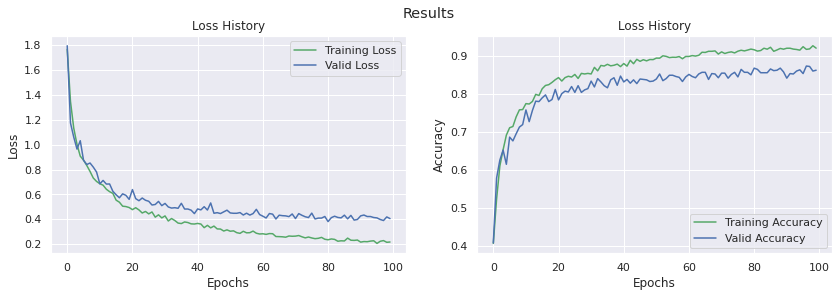

In [21]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history2 = trainer2.getHistory()
trainer2.showResults()

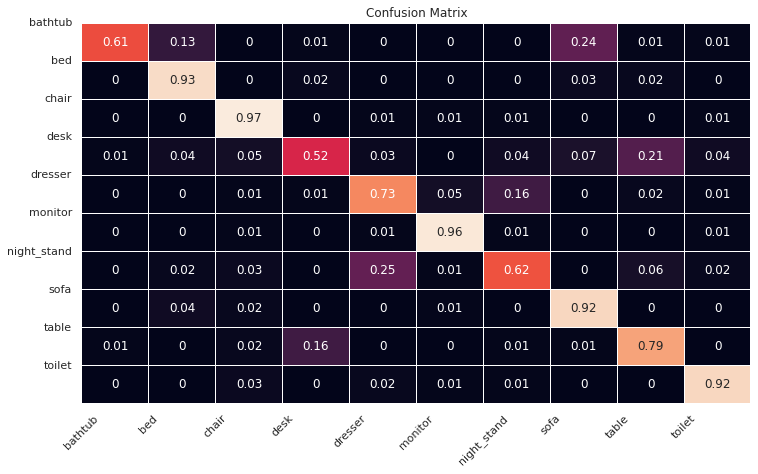

In [22]:
trainer2.generateConfusionMatrix()

In [23]:
trainer2.getPerClassAccuracy()

{'bathtub': 60.39604187011719, 'bed': 93.00000762939453, 'chair': 96.03960418701172, 'desk': 51.48514938354492, 'dresser': 73.73737335205078, 'monitor': 96.00000762939453, 'night_stand': 61.386138916015625, 'sofa': 92.92929077148438, 'table': 79.0, 'toilet': 92.9292984008789}


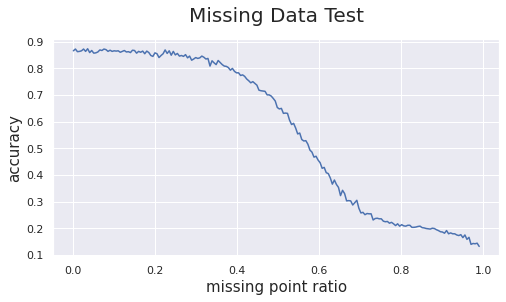

In [24]:
trainer2.missing_data_test()

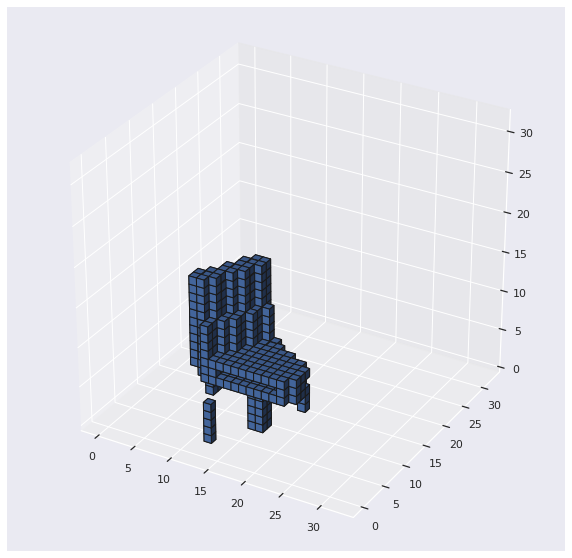

In [25]:
trainer2.draw_voxels()

**DMPVoxNet** training

In [26]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'DMPVoxNet'
}    

trainer3 = VoxNet_Trainer(training_hyperparameters)
trainer3.train()

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


model DMPVoxNet was chosen
124.71875


Train loss: 1.3460888862609863: : 124it [00:53,  2.30it/s]
29it [00:08,  3.37it/s]


epoch:  1 /100
time: 62.50 seconds
train-loss: 1.88, train-acc: 34.30%
valid-loss: 1.95, valid-acc: 26.87%



Train loss: 1.72646963596344: : 124it [00:54,  2.28it/s]
29it [00:08,  3.32it/s]


epoch:  2 /100
time: 63.03 seconds
train-loss: 1.53, train-acc: 47.58%
valid-loss: 1.64, valid-acc: 37.11%



Train loss: 1.4228335618972778: : 124it [00:53,  2.30it/s]
29it [00:08,  3.34it/s]


epoch:  3 /100
time: 62.71 seconds
train-loss: 1.33, train-acc: 53.35%
valid-loss: 1.40, valid-acc: 49.56%



Train loss: 0.8824144601821899: : 124it [00:54,  2.29it/s]
29it [00:08,  3.33it/s]


epoch:  4 /100
time: 62.87 seconds
train-loss: 1.19, train-acc: 58.39%
valid-loss: 1.21, valid-acc: 58.92%



Train loss: 1.2527073621749878: : 124it [00:54,  2.30it/s]
29it [00:08,  3.35it/s]


epoch:  5 /100
time: 62.69 seconds
train-loss: 1.11, train-acc: 61.27%
valid-loss: 1.12, valid-acc: 60.90%



Train loss: 0.6447142362594604: : 124it [00:53,  2.30it/s]
29it [00:08,  3.37it/s]


epoch:  6 /100
time: 62.53 seconds
train-loss: 1.03, train-acc: 64.52%
valid-loss: 1.14, valid-acc: 60.35%



Train loss: 0.8818396925926208: : 124it [00:53,  2.30it/s]
29it [00:08,  3.36it/s]


epoch:  7 /100
time: 62.61 seconds
train-loss: 0.96, train-acc: 67.52%
valid-loss: 0.97, valid-acc: 67.40%



Train loss: 0.6952789425849915: : 124it [00:53,  2.30it/s]
29it [00:08,  3.35it/s]


epoch:  8 /100
time: 62.58 seconds
train-loss: 0.91, train-acc: 67.69%
valid-loss: 1.03, valid-acc: 64.65%



Train loss: 0.8239118456840515: : 124it [00:53,  2.30it/s]
29it [00:08,  3.35it/s]


epoch:  9 /100
time: 62.59 seconds
train-loss: 0.88, train-acc: 70.04%
valid-loss: 0.98, valid-acc: 66.30%



Train loss: 0.5211606025695801: : 124it [00:54,  2.29it/s]
29it [00:08,  3.34it/s]


epoch: 10 /100
time: 62.78 seconds
train-loss: 0.80, train-acc: 72.71%
valid-loss: 0.97, valid-acc: 67.29%



Train loss: 0.5946897268295288: : 124it [00:53,  2.30it/s]
29it [00:08,  3.32it/s]


epoch: 11 /100
time: 62.69 seconds
train-loss: 0.81, train-acc: 73.54%
valid-loss: 0.94, valid-acc: 66.52%



Train loss: 0.8278869390487671: : 124it [00:54,  2.30it/s]
29it [00:08,  3.35it/s]


epoch: 12 /100
time: 62.73 seconds
train-loss: 0.79, train-acc: 74.70%
valid-loss: 0.91, valid-acc: 69.05%



Train loss: 0.6544613838195801: : 124it [00:54,  2.29it/s]
29it [00:08,  3.34it/s]


epoch: 13 /100
time: 62.80 seconds
train-loss: 0.75, train-acc: 74.42%
valid-loss: 0.85, valid-acc: 71.15%



Train loss: 0.6095049977302551: : 124it [00:54,  2.29it/s]
29it [00:08,  3.32it/s]


epoch: 14 /100
time: 62.90 seconds
train-loss: 0.73, train-acc: 74.37%
valid-loss: 0.87, valid-acc: 69.93%



Train loss: 0.5992891788482666: : 124it [00:54,  2.29it/s]
29it [00:08,  3.35it/s]


epoch: 15 /100
time: 62.79 seconds
train-loss: 0.72, train-acc: 74.95%
valid-loss: 0.84, valid-acc: 71.15%



Train loss: 0.5970264673233032: : 124it [00:53,  2.32it/s]
29it [00:08,  3.38it/s]


epoch: 16 /100
time: 62.17 seconds
train-loss: 0.68, train-acc: 77.32%
valid-loss: 0.82, valid-acc: 71.92%



Train loss: 0.9155182838439941: : 124it [00:53,  2.31it/s]
29it [00:08,  3.37it/s]


epoch: 17 /100
time: 62.40 seconds
train-loss: 0.66, train-acc: 77.97%
valid-loss: 0.81, valid-acc: 72.58%



Train loss: 0.6266748309135437: : 124it [00:53,  2.32it/s]
29it [00:08,  3.39it/s]


epoch: 18 /100
time: 62.08 seconds
train-loss: 0.65, train-acc: 78.33%
valid-loss: 0.77, valid-acc: 72.36%



Train loss: 0.4530409574508667: : 124it [00:53,  2.31it/s]
29it [00:08,  3.37it/s]


epoch: 19 /100
time: 62.23 seconds
train-loss: 0.64, train-acc: 78.63%
valid-loss: 0.77, valid-acc: 73.02%



Train loss: 0.620204746723175: : 124it [00:53,  2.30it/s]
29it [00:08,  3.32it/s]


epoch: 20 /100
time: 62.73 seconds
train-loss: 0.63, train-acc: 78.81%
valid-loss: 0.78, valid-acc: 73.13%



Train loss: 0.7618803381919861: : 124it [00:53,  2.30it/s]
29it [00:08,  3.35it/s]


epoch: 21 /100
time: 62.62 seconds
train-loss: 0.64, train-acc: 79.16%
valid-loss: 0.76, valid-acc: 73.46%



Train loss: 0.712160587310791: : 124it [00:53,  2.30it/s]
29it [00:08,  3.35it/s]


epoch: 22 /100
time: 62.66 seconds
train-loss: 0.63, train-acc: 78.60%
valid-loss: 0.73, valid-acc: 74.78%



Train loss: 0.454448401927948: : 124it [00:53,  2.30it/s]
29it [00:08,  3.33it/s]


epoch: 23 /100
time: 62.72 seconds
train-loss: 0.60, train-acc: 80.47%
valid-loss: 0.75, valid-acc: 75.33%



Train loss: 0.5748581886291504: : 124it [00:53,  2.30it/s]
29it [00:08,  3.37it/s]


epoch: 24 /100
time: 62.57 seconds
train-loss: 0.60, train-acc: 79.64%
valid-loss: 0.72, valid-acc: 75.55%



Train loss: 0.2825564444065094: : 124it [00:53,  2.30it/s]
29it [00:08,  3.36it/s]


epoch: 25 /100
time: 62.59 seconds
train-loss: 0.60, train-acc: 80.12%
valid-loss: 0.66, valid-acc: 77.75%



Train loss: 0.31559115648269653: : 124it [00:53,  2.31it/s]
29it [00:08,  3.33it/s]


epoch: 26 /100
time: 62.52 seconds
train-loss: 0.59, train-acc: 79.89%
valid-loss: 0.71, valid-acc: 74.78%



Train loss: 0.4888971745967865: : 124it [00:54,  2.28it/s]
29it [00:08,  3.34it/s]


epoch: 27 /100
time: 62.99 seconds
train-loss: 0.57, train-acc: 80.47%
valid-loss: 0.70, valid-acc: 77.20%



Train loss: 0.47334161400794983: : 124it [00:54,  2.29it/s]
29it [00:08,  3.34it/s]


epoch: 28 /100
time: 62.79 seconds
train-loss: 0.57, train-acc: 80.70%
valid-loss: 0.65, valid-acc: 77.20%



Train loss: 0.4890744090080261: : 124it [00:54,  2.28it/s]
29it [00:08,  3.31it/s]


epoch: 29 /100
time: 63.25 seconds
train-loss: 0.56, train-acc: 81.53%
valid-loss: 0.65, valid-acc: 78.19%



Train loss: 0.4448016881942749: : 124it [00:55,  2.25it/s]
29it [00:09,  3.06it/s]


epoch: 30 /100
time: 64.54 seconds
train-loss: 0.57, train-acc: 80.59%
valid-loss: 0.67, valid-acc: 78.96%



Train loss: 0.3421649634838104: : 124it [00:56,  2.21it/s]
29it [00:08,  3.26it/s]


epoch: 31 /100
time: 65.12 seconds
train-loss: 0.55, train-acc: 81.48%
valid-loss: 0.65, valid-acc: 77.53%



Train loss: 0.6139218211174011: : 124it [00:56,  2.21it/s]
29it [00:09,  3.15it/s]


epoch: 32 /100
time: 65.26 seconds
train-loss: 0.53, train-acc: 82.23%
valid-loss: 0.67, valid-acc: 77.64%



Train loss: 0.6294687390327454: : 124it [00:55,  2.24it/s]
29it [00:08,  3.31it/s]


epoch: 33 /100
time: 64.14 seconds
train-loss: 0.53, train-acc: 82.64%
valid-loss: 0.62, valid-acc: 78.74%



Train loss: 0.39968058466911316: : 124it [00:54,  2.28it/s]
29it [00:08,  3.30it/s]


epoch: 34 /100
time: 63.23 seconds
train-loss: 0.50, train-acc: 82.54%
valid-loss: 0.63, valid-acc: 79.74%



Train loss: 0.7875264883041382: : 124it [00:54,  2.26it/s]
29it [00:08,  3.30it/s]


epoch: 35 /100
time: 63.60 seconds
train-loss: 0.51, train-acc: 82.89%
valid-loss: 0.64, valid-acc: 79.85%



Train loss: 0.6836037635803223: : 124it [00:54,  2.27it/s]
29it [00:08,  3.28it/s]


epoch: 36 /100
time: 63.51 seconds
train-loss: 0.49, train-acc: 83.17%
valid-loss: 0.62, valid-acc: 79.19%



Train loss: 0.27632254362106323: : 124it [00:54,  2.28it/s]
29it [00:08,  3.32it/s]


epoch: 37 /100
time: 63.23 seconds
train-loss: 0.51, train-acc: 83.29%
valid-loss: 0.62, valid-acc: 79.85%



Train loss: 0.3181036710739136: : 124it [00:54,  2.28it/s]
29it [00:08,  3.34it/s]


epoch: 38 /100
time: 63.11 seconds
train-loss: 0.49, train-acc: 83.77%
valid-loss: 0.61, valid-acc: 81.28%



Train loss: 0.42540180683135986: : 124it [00:54,  2.30it/s]
29it [00:08,  3.32it/s]


epoch: 39 /100
time: 62.78 seconds
train-loss: 0.49, train-acc: 83.57%
valid-loss: 0.60, valid-acc: 78.96%



Train loss: 0.2583194077014923: : 124it [00:54,  2.28it/s]
29it [00:08,  3.33it/s]


epoch: 40 /100
time: 63.15 seconds
train-loss: 0.49, train-acc: 83.37%
valid-loss: 0.62, valid-acc: 78.74%



Train loss: 0.3486436903476715: : 124it [00:54,  2.29it/s]
29it [00:08,  3.31it/s]


epoch: 41 /100
time: 62.90 seconds
train-loss: 0.48, train-acc: 83.72%
valid-loss: 0.60, valid-acc: 79.07%



Train loss: 0.22603708505630493: : 124it [00:54,  2.29it/s]
29it [00:08,  3.33it/s]


epoch: 42 /100
time: 62.78 seconds
train-loss: 0.50, train-acc: 82.76%
valid-loss: 0.59, valid-acc: 80.40%



Train loss: 0.531867504119873: : 124it [00:53,  2.31it/s]
29it [00:08,  3.35it/s]


epoch: 43 /100
time: 62.31 seconds
train-loss: 0.48, train-acc: 83.90%
valid-loss: 0.58, valid-acc: 80.62%



Train loss: 0.8672131896018982: : 124it [00:53,  2.30it/s]
29it [00:08,  3.31it/s]


epoch: 44 /100
time: 62.76 seconds
train-loss: 0.48, train-acc: 84.45%
valid-loss: 0.59, valid-acc: 81.61%



Train loss: 0.42233139276504517: : 124it [00:54,  2.29it/s]
29it [00:08,  3.33it/s]


epoch: 45 /100
time: 62.92 seconds
train-loss: 0.46, train-acc: 84.75%
valid-loss: 0.63, valid-acc: 79.96%



Train loss: 0.6476688385009766: : 124it [00:53,  2.30it/s]
29it [00:08,  3.33it/s]


epoch: 46 /100
time: 62.62 seconds
train-loss: 0.48, train-acc: 83.42%
valid-loss: 0.62, valid-acc: 79.52%



Train loss: 0.4886312186717987: : 124it [00:53,  2.30it/s]
29it [00:08,  3.33it/s]


epoch: 47 /100
time: 62.62 seconds
train-loss: 0.45, train-acc: 84.45%
valid-loss: 0.63, valid-acc: 78.96%



Train loss: 0.1761915236711502: : 124it [00:54,  2.29it/s]
29it [00:08,  3.37it/s]


epoch: 48 /100
time: 62.81 seconds
train-loss: 0.45, train-acc: 84.90%
valid-loss: 0.63, valid-acc: 78.08%



Train loss: 0.5538272261619568: : 124it [00:53,  2.30it/s]
29it [00:08,  3.36it/s]


epoch: 49 /100
time: 62.50 seconds
train-loss: 0.47, train-acc: 83.85%
valid-loss: 0.59, valid-acc: 80.62%



Train loss: 0.4514909088611603: : 124it [00:53,  2.31it/s]
29it [00:08,  3.33it/s]


epoch: 50 /100
time: 62.47 seconds
train-loss: 0.44, train-acc: 85.26%
valid-loss: 0.56, valid-acc: 80.40%



Train loss: 0.4520750641822815: : 124it [00:53,  2.30it/s]
29it [00:08,  3.30it/s]


epoch: 51 /100
time: 62.68 seconds
train-loss: 0.46, train-acc: 84.22%
valid-loss: 0.59, valid-acc: 79.96%



Train loss: 0.38046151399612427: : 124it [00:54,  2.29it/s]
29it [00:08,  3.34it/s]


epoch: 52 /100
time: 62.77 seconds
train-loss: 0.44, train-acc: 85.26%
valid-loss: 0.64, valid-acc: 79.41%



Train loss: 0.40313848853111267: : 124it [00:54,  2.30it/s]
29it [00:08,  3.35it/s]


epoch: 53 /100
time: 62.70 seconds
train-loss: 0.44, train-acc: 84.60%
valid-loss: 0.59, valid-acc: 80.95%



Train loss: 0.4770410656929016: : 124it [00:54,  2.29it/s]
29it [00:08,  3.34it/s]


epoch: 54 /100
time: 62.77 seconds
train-loss: 0.44, train-acc: 84.80%
valid-loss: 0.56, valid-acc: 80.51%



Train loss: 0.3446541726589203: : 124it [00:53,  2.30it/s]
29it [00:08,  3.34it/s]


epoch: 55 /100
time: 62.67 seconds
train-loss: 0.43, train-acc: 85.38%
valid-loss: 0.61, valid-acc: 80.84%



Train loss: 0.4743160307407379: : 124it [00:53,  2.30it/s]
29it [00:08,  3.34it/s]


epoch: 56 /100
time: 62.62 seconds
train-loss: 0.42, train-acc: 85.41%
valid-loss: 0.58, valid-acc: 81.39%



Train loss: 0.39545199275016785: : 124it [00:53,  2.30it/s]
29it [00:08,  3.36it/s]


epoch: 57 /100
time: 62.50 seconds
train-loss: 0.43, train-acc: 85.31%
valid-loss: 0.60, valid-acc: 81.28%



Train loss: 0.42113062739372253: : 124it [00:53,  2.30it/s]
29it [00:08,  3.32it/s]


epoch: 58 /100
time: 62.62 seconds
train-loss: 0.43, train-acc: 85.79%
valid-loss: 0.57, valid-acc: 80.07%



Train loss: 0.3716771900653839: : 124it [00:54,  2.28it/s]
29it [00:08,  3.31it/s]


epoch: 59 /100
time: 63.16 seconds
train-loss: 0.43, train-acc: 85.69%
valid-loss: 0.56, valid-acc: 81.28%



Train loss: 0.4735470116138458: : 124it [00:53,  2.30it/s]
29it [00:08,  3.30it/s]


epoch: 60 /100
time: 62.83 seconds
train-loss: 0.43, train-acc: 85.99%
valid-loss: 0.58, valid-acc: 79.85%



Train loss: 0.3471883237361908: : 124it [00:54,  2.29it/s]
29it [00:08,  3.33it/s]


epoch: 61 /100
time: 62.93 seconds
train-loss: 0.44, train-acc: 85.69%
valid-loss: 0.52, valid-acc: 81.61%



Train loss: 0.31369635462760925: : 124it [00:53,  2.30it/s]
29it [00:08,  3.35it/s]


epoch: 62 /100
time: 62.50 seconds
train-loss: 0.42, train-acc: 86.14%
valid-loss: 0.55, valid-acc: 81.83%



Train loss: 0.5606814622879028: : 124it [00:54,  2.30it/s]
29it [00:08,  3.36it/s]


epoch: 63 /100
time: 62.68 seconds
train-loss: 0.41, train-acc: 85.43%
valid-loss: 0.57, valid-acc: 82.27%



Train loss: 0.31362271308898926: : 124it [00:53,  2.30it/s]
29it [00:08,  3.33it/s]


epoch: 64 /100
time: 62.65 seconds
train-loss: 0.40, train-acc: 86.16%
valid-loss: 0.58, valid-acc: 81.61%



Train loss: 0.8252235054969788: : 124it [00:54,  2.29it/s]
29it [00:08,  3.34it/s]


epoch: 65 /100
time: 62.95 seconds
train-loss: 0.42, train-acc: 85.58%
valid-loss: 0.54, valid-acc: 82.82%



Train loss: 0.7058075666427612: : 124it [00:54,  2.29it/s]
29it [00:08,  3.35it/s]


epoch: 66 /100
time: 62.83 seconds
train-loss: 0.40, train-acc: 86.37%
valid-loss: 0.56, valid-acc: 80.84%



Train loss: 0.569888710975647: : 124it [00:54,  2.29it/s]
29it [00:08,  3.33it/s]


epoch: 67 /100
time: 62.83 seconds
train-loss: 0.41, train-acc: 85.81%
valid-loss: 0.57, valid-acc: 82.16%



Train loss: 0.6674399971961975: : 124it [00:55,  2.23it/s]
29it [00:08,  3.36it/s]


epoch: 68 /100
time: 64.27 seconds
train-loss: 0.40, train-acc: 85.71%
valid-loss: 0.56, valid-acc: 80.51%



Train loss: 0.2821374535560608: : 124it [00:53,  2.30it/s]
29it [00:08,  3.30it/s]


epoch: 69 /100
time: 62.73 seconds
train-loss: 0.41, train-acc: 86.04%
valid-loss: 0.58, valid-acc: 82.05%



Train loss: 0.4325048327445984: : 124it [00:54,  2.26it/s]
29it [00:08,  3.33it/s]


epoch: 70 /100
time: 63.49 seconds
train-loss: 0.39, train-acc: 87.00%
valid-loss: 0.58, valid-acc: 81.83%



Train loss: 0.35022181272506714: : 124it [00:54,  2.29it/s]
29it [00:08,  3.35it/s]


epoch: 71 /100
time: 62.89 seconds
train-loss: 0.39, train-acc: 86.97%
valid-loss: 0.58, valid-acc: 82.27%



Train loss: 0.38134685158729553: : 124it [00:53,  2.30it/s]
29it [00:08,  3.35it/s]


epoch: 72 /100
time: 62.65 seconds
train-loss: 0.40, train-acc: 86.14%
valid-loss: 0.57, valid-acc: 81.94%



Train loss: 0.48819413781166077: : 124it [00:53,  2.30it/s]
29it [00:08,  3.36it/s]


epoch: 73 /100
time: 62.63 seconds
train-loss: 0.41, train-acc: 86.14%
valid-loss: 0.54, valid-acc: 82.16%



Train loss: 0.3247661590576172: : 124it [00:54,  2.29it/s]
29it [00:08,  3.35it/s]


epoch: 74 /100
time: 62.75 seconds
train-loss: 0.41, train-acc: 86.77%
valid-loss: 0.58, valid-acc: 81.17%



Train loss: 0.48746457695961: : 124it [00:53,  2.30it/s]
29it [00:08,  3.39it/s]


epoch: 75 /100
time: 62.53 seconds
train-loss: 0.40, train-acc: 86.19%
valid-loss: 0.54, valid-acc: 84.36%



Train loss: 0.43110641837120056: : 124it [00:53,  2.30it/s]
29it [00:08,  3.35it/s]


epoch: 76 /100
time: 62.59 seconds
train-loss: 0.38, train-acc: 87.07%
valid-loss: 0.54, valid-acc: 81.83%



Train loss: 0.2549382448196411: : 124it [00:54,  2.29it/s]
29it [00:08,  3.37it/s]


epoch: 77 /100
time: 62.70 seconds
train-loss: 0.38, train-acc: 87.50%
valid-loss: 0.54, valid-acc: 81.61%



Train loss: 0.3335214853286743: : 124it [00:53,  2.30it/s]
29it [00:08,  3.33it/s]


epoch: 78 /100
time: 62.75 seconds
train-loss: 0.40, train-acc: 87.02%
valid-loss: 0.54, valid-acc: 81.28%



Train loss: 0.3211788833141327: : 124it [00:54,  2.29it/s]
29it [00:08,  3.35it/s]


epoch: 79 /100
time: 62.76 seconds
train-loss: 0.38, train-acc: 86.82%
valid-loss: 0.55, valid-acc: 82.71%



Train loss: 0.20594343543052673: : 124it [00:54,  2.29it/s]
29it [00:08,  3.34it/s]


epoch: 80 /100
time: 62.81 seconds
train-loss: 0.41, train-acc: 86.29%
valid-loss: 0.54, valid-acc: 82.16%



Train loss: 0.239229217171669: : 124it [00:54,  2.29it/s]
29it [00:08,  3.33it/s]


epoch: 81 /100
time: 62.85 seconds
train-loss: 0.37, train-acc: 87.20%
valid-loss: 0.56, valid-acc: 81.17%



Train loss: 0.17759191989898682: : 124it [00:54,  2.29it/s]
29it [00:08,  3.34it/s]


epoch: 82 /100
time: 62.79 seconds
train-loss: 0.38, train-acc: 87.07%
valid-loss: 0.55, valid-acc: 82.71%



Train loss: 0.3664849102497101: : 124it [00:54,  2.29it/s]
29it [00:08,  3.33it/s]


epoch: 83 /100
time: 62.82 seconds
train-loss: 0.39, train-acc: 86.37%
valid-loss: 0.54, valid-acc: 83.81%



Train loss: 0.5469299554824829: : 124it [00:54,  2.29it/s]
29it [00:08,  3.34it/s]


epoch: 84 /100
time: 62.79 seconds
train-loss: 0.38, train-acc: 87.40%
valid-loss: 0.54, valid-acc: 81.61%



Train loss: 0.3037419617176056: : 124it [00:54,  2.29it/s]
29it [00:08,  3.32it/s]


epoch: 85 /100
time: 62.87 seconds
train-loss: 0.38, train-acc: 86.64%
valid-loss: 0.52, valid-acc: 84.14%



Train loss: 0.6480221748352051: : 124it [00:54,  2.28it/s]
29it [00:08,  3.30it/s]


epoch: 86 /100
time: 63.12 seconds
train-loss: 0.39, train-acc: 86.90%
valid-loss: 0.54, valid-acc: 81.61%



Train loss: 0.5988583564758301: : 124it [00:54,  2.29it/s]
29it [00:08,  3.36it/s]


epoch: 87 /100
time: 62.75 seconds
train-loss: 0.38, train-acc: 87.10%
valid-loss: 0.56, valid-acc: 81.50%



Train loss: 0.6041340827941895: : 124it [00:53,  2.30it/s]
29it [00:08,  3.36it/s]


epoch: 88 /100
time: 62.61 seconds
train-loss: 0.37, train-acc: 87.15%
valid-loss: 0.53, valid-acc: 81.94%



Train loss: 0.36080124974250793: : 124it [00:54,  2.29it/s]
29it [00:08,  3.33it/s]


epoch: 89 /100
time: 62.84 seconds
train-loss: 0.37, train-acc: 87.78%
valid-loss: 0.53, valid-acc: 81.50%



Train loss: 0.18755073845386505: : 124it [00:53,  2.30it/s]
29it [00:08,  3.33it/s]


epoch: 90 /100
time: 62.69 seconds
train-loss: 0.37, train-acc: 87.15%
valid-loss: 0.54, valid-acc: 82.49%



Train loss: 0.40225476026535034: : 124it [00:54,  2.29it/s]
29it [00:08,  3.34it/s]


epoch: 91 /100
time: 62.78 seconds
train-loss: 0.39, train-acc: 86.77%
valid-loss: 0.52, valid-acc: 82.49%



Train loss: 0.27947506308555603: : 124it [00:53,  2.30it/s]
29it [00:08,  3.33it/s]


epoch: 92 /100
time: 62.66 seconds
train-loss: 0.38, train-acc: 86.72%
valid-loss: 0.55, valid-acc: 82.27%



Train loss: 0.19359073042869568: : 124it [00:53,  2.30it/s]
29it [00:08,  3.33it/s]


epoch: 93 /100
time: 62.62 seconds
train-loss: 0.37, train-acc: 87.12%
valid-loss: 0.57, valid-acc: 81.28%



Train loss: 0.3473597466945648: : 124it [00:53,  2.30it/s]
29it [00:08,  3.35it/s]


epoch: 94 /100
time: 62.59 seconds
train-loss: 0.37, train-acc: 87.83%
valid-loss: 0.53, valid-acc: 82.71%



Train loss: 0.2913961410522461: : 124it [00:53,  2.32it/s]
29it [00:08,  3.40it/s]


epoch: 95 /100
time: 62.06 seconds
train-loss: 0.37, train-acc: 87.22%
valid-loss: 0.55, valid-acc: 82.82%



Train loss: 0.5548960566520691: : 124it [00:54,  2.29it/s]
29it [00:08,  3.37it/s]


epoch: 96 /100
time: 62.74 seconds
train-loss: 0.37, train-acc: 87.53%
valid-loss: 0.55, valid-acc: 82.27%



Train loss: 0.49265971779823303: : 124it [00:54,  2.28it/s]
29it [00:08,  3.33it/s]


epoch: 97 /100
time: 63.10 seconds
train-loss: 0.36, train-acc: 87.58%
valid-loss: 0.56, valid-acc: 81.50%



Train loss: 0.24501776695251465: : 124it [00:54,  2.29it/s]
29it [00:08,  3.34it/s]


epoch: 98 /100
time: 62.76 seconds
train-loss: 0.38, train-acc: 87.35%
valid-loss: 0.54, valid-acc: 82.05%



Train loss: 0.49920469522476196: : 124it [00:54,  2.29it/s]
29it [00:08,  3.33it/s]


epoch: 99 /100
time: 62.99 seconds
train-loss: 0.37, train-acc: 87.45%
valid-loss: 0.57, valid-acc: 81.94%



Train loss: 0.3401060104370117: : 124it [00:54,  2.29it/s]
29it [00:08,  3.36it/s]

epoch:100 /100
time: 62.94 seconds
train-loss: 0.37, train-acc: 87.30%
valid-loss: 0.54, valid-acc: 83.37%



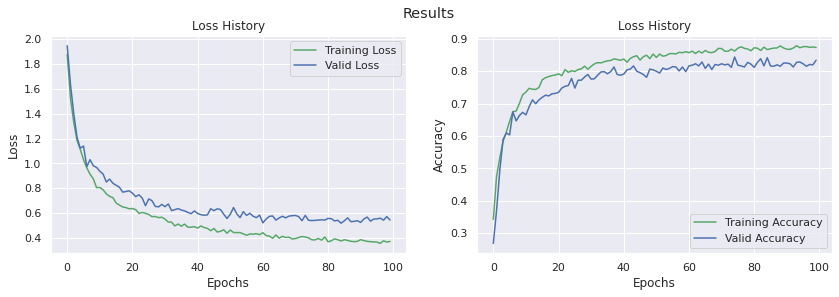

In [27]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history3 = trainer3.getHistory()
trainer3.showResults()

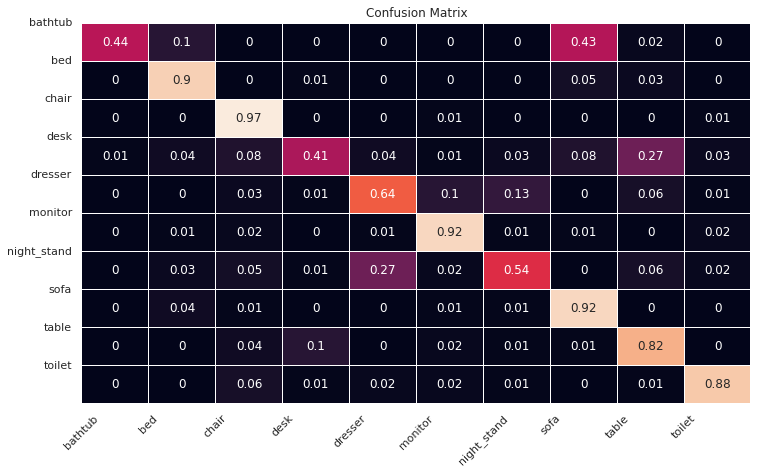

In [28]:
trainer3.generateConfusionMatrix()

In [29]:
trainer3.getPerClassAccuracy()

{'bathtub': 44.44444274902344, 'bed': 90.90909576416016, 'chair': 97.97979736328125, 'desk': 41.0, 'dresser': 65.30612182617188, 'monitor': 92.0, 'night_stand': 54.000003814697266, 'sofa': 92.92929077148438, 'table': 82.0, 'toilet': 87.12871551513672}


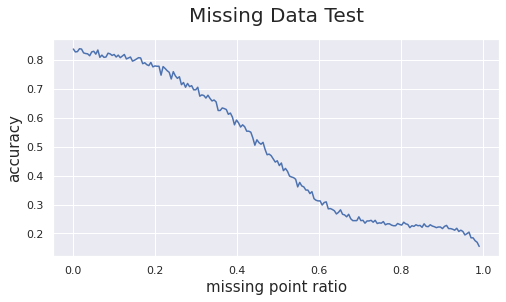

In [30]:
trainer3.missing_data_test()

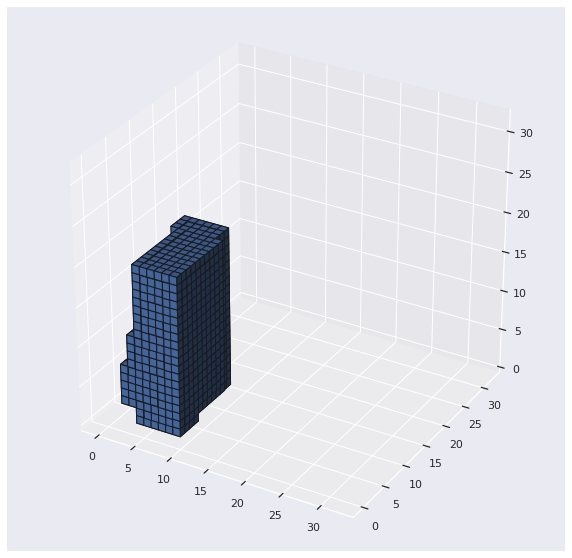

In [31]:
trainer3.draw_voxels()

Results

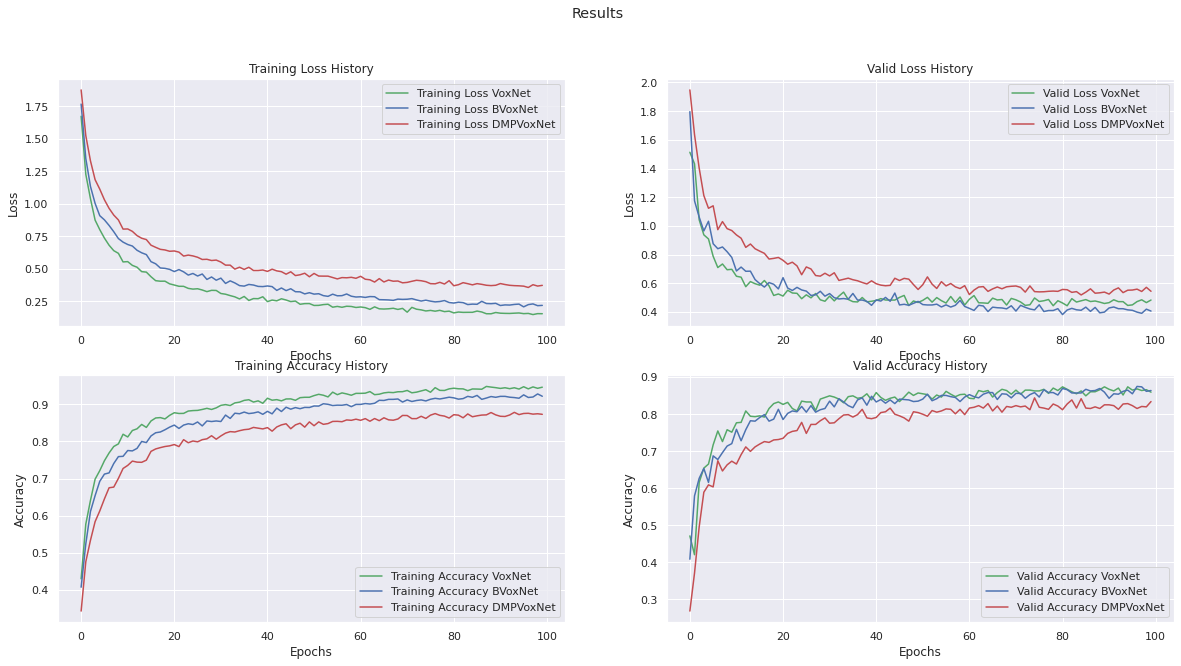

In [38]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history1["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history1["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history2["train_loss"].cpu()), 'b', label='Training Loss BVoxNet')
ax[0,0].plot(eps, smooth(history3["train_loss"].cpu()), 'r', label='Training Loss DMPVoxNet')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history1["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history2["valid_loss"].cpu()), 'b', label='Valid Loss BVoxNet')
ax[0,1].plot(eps, smooth(history3["valid_loss"].cpu()), 'r', label='Valid Loss DMPVoxNet')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history1["train_acc"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history2["train_acc"].cpu()), 'b', label='Training Accuracy BVoxNet')
ax[1,0].plot(eps, smooth(history3["train_acc"].cpu()), 'r', label='Training Accuracy DMPVoxNet')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history1["valid_acc"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history2["valid_acc"].cpu()), 'b', label='Valid Accuracy BVoxNet')
ax[1,1].plot(eps, smooth(history3["valid_acc"].cpu()), 'r', label='Valid Accuracy DMPVoxNet')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()